Grabbing list of artists

In [ ]:
import pandas as pd

df = pd.read_csv("listeners.csv")
df = df.drop(columns=['Listeners', 'Daily Trend', 'Peak', 'PkListeners'])
df.to_csv("artists.csv", index=False)
df.head()

Scrapping artists URI's

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from dotenv import load_dotenv
import os
import pandas as pd

# Set up authentication with your Spotify Developer credentials
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id= client_id,
    client_secret= client_secret
))

df = pd.read_csv("artists.csv")
artist_names = df['Artist'].tolist()

artists_list = []
uris_list = []

for artist_name in artist_names:
    results = sp.search(q='artist:' + artist_name, type='artist', limit=1)
    items = results['artists']['items']

    if items:
        artist = items[0]
        artist_uri = artist['uri']
        print(f"Artist URI for '{artist_name}': {artist_uri}")
        # Append to lists
        artists_list.append(artist_name)
        uris_list.append(artist_uri)
    else:
        print(f"Artist '{artist_name}' not found.")
        # Append name with None URI
        artists_list.append(artist_name)
        uris_list.append(None)

# Create a DataFrame with the results
result_df = pd.DataFrame({
    "Artists": artists_list,
    "URI": uris_list
})

# Save to CSV
result_df.to_csv("artist_uris.csv", index=False)

Getting Track ID's

In [ ]:
# Load CSV with columns 'Artist' and 'URI'
df = pd.read_csv('artists_uris_cleaned.csv')

# Prepare lists to collect results
track_names = []
album_names = []
artist_names_all = []
track_uris = []

for artist_name, artist_uri in zip(df['Artists'], df['URI']):
    artist_id = artist_uri.split(":")[-1]
    
    # Get all albums by the artist (limit and offset used to get all pages)
    albums = []
    offset = 0
    while True:
        results = sp.artist_albums(artist_id, album_type='album,single', limit=50, offset=offset)
        albums.extend(results['items'])
        if results['next'] is None:
            break
        offset += 50

    # For each album get the tracks
    for album in albums:
        album_name = album['name']
        album_id = album['id']

        # Get tracks for the album
        tracks = []
        track_offset = 0
        while True:
            track_results = sp.album_tracks(album_id, limit=50, offset=track_offset)
            tracks.extend(track_results['items'])
            if track_results['next'] is None:
                break
            track_offset += 50

        # For each track, get the track name, artists, and URI
        for track in tracks:
            track_name = track['name']
            track_uri = track['uri']
            artists = [artist['name'] for artist in track['artists']]
            artists_str = ", ".join(artists)

            track_names.append(track_name)
            track_uris.append(track_uri)
            album_names.append(album_name)
            artist_names_all.append(artists_str)

            # Print the track info as it is added
            print(f"Added Track: '{track_name}' by {artists_str} from Album: '{album_name}', URI: {track_uri}")

    print(f"Fetched {len(track_names)} tracks so far for artist '{artist_name}'")

# Create a DataFrame with the collected data
result_df = pd.DataFrame({
    'Track Name': track_names,
    'Album Name': album_names,
    'Artist(s)': artist_names_all,
    'Track URI': track_uris
})

# Save to CSV
result_df.to_csv('artist_tracks_album_info.csv', index=False)

print(f"Saved {len(result_df)} tracks to artist_tracks_album_info.csv")


In [ ]:
## Trying to only take one album from each artist
# Load CSV with columns 'Artist' and 'URI'
df = pd.read_csv('artists_uris_cleaned.csv')

# Prepare lists to collect results
track_names = []
album_names = []
artist_names_all = []

for artist_name, artist_uri in zip(df['Artists'], df['URI']):
    artist_id = artist_uri.split(":")[-1]
    
    # Get the first album only (no pagination)
    results = sp.artist_albums(artist_id, album_type='album,single', limit=1, offset=0)
    albums = results['items']

    if not albums:
        print(f"No albums found for artist '{artist_name}'")
        continue

    album = albums[0]
    album_name = album['name']
    album_id = album['id']

    # Get tracks for the album
    tracks = []
    track_offset = 0
    while True:
        track_results = sp.album_tracks(album_id, limit=50, offset=track_offset)
        tracks.extend(track_results['items'])
        if track_results['next'] is None:
            break
        track_offset += 50

    # For each track, get the track name and artists only (remove URI)
    for track in tracks:
        track_name = track['name']
        artists = [artist['name'] for artist in track['artists']]
        artists_str = ", ".join(artists)

        track_names.append(track_name)
        album_names.append(album_name)
        artist_names_all.append(artists_str)

        # Print the track info as it is added (no URI included)
        print(f"Added Track: '{track_name}' by {artists_str} from Album: '{album_name}'")

    print(f"Fetched {len(track_names)} tracks so far for artist '{artist_name}'")

# Create a DataFrame with the collected data (no URI column)
result_df = pd.DataFrame({
    'Track Name': track_names,
    'Album Name': album_names,
    'Artist(s)': artist_names_all
})

# Save to CSV
result_df.to_csv('artist_tracks_album_info.csv', index=False)

print(f"Saved {len(result_df)} tracks to artist_tracks_album_info.csv")


In [ ]:
from spotipy.oauth2 import SpotifyOAuth
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id= client_id,
                                               client_secret= client_secret,
                                               redirect_uri="https://google.com/",
                                               scope="user-library-read"))

Tring MusicBrainz API, Spotify API is deprecated

In [ ]:
import requests

def get_recording_mbid(artist_name, track_name):
    """Search MusicBrainz for recording MBID by artist and track name."""
    query = f'artist:"{artist_name}" AND recording:"{track_name}"'
    url = "https://musicbrainz.org/ws/2/recording/"
    headers = {
        'User-Agent': 'ai-dj/1.0 (donutzay@gmail.com)'
    }
    params = {
        'query': query,
        'fmt': 'json',
        'limit': 1
    }
    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    data = response.json()
    if data['recordings']:
        mbid = data['recordings'][0]['id']
        print(f"Found recording MBID: {mbid}")
        return mbid
    else:
        print("Recording MBID not found")
        return None

def get_acoustic_features(mbid):
    """Fetch audio features from AcousticBrainz using MusicBrainz recording MBID."""
    url = f"https://acousticbrainz.org/api/v1/{mbid}/low-level"
    response = requests.get(url)
    if response.status_code == 404:
        print(f"No AcousticBrainz data found for MBID {mbid}")
        return None
    response.raise_for_status()
    features = response.json()
    print(f"Retrieved AcousticBrainz features for MBID: {mbid}")
    return features

# Example usage in Jupyter notebook:
artist = "Drake"
track = "Controlla"

mbid = get_recording_mbid(artist, track)
if mbid:
    features = get_acoustic_features(mbid)
    if features:
        # Display some keys from the features for inspection
        print("Some AcousticBrainz feature keys:")
        print(list(features.keys())[:10])
else:
    print("Could not retrieve AcousticBrainz features.")


Uses libRosa and Deezer to download a preview of a song and perform feature extraction

Preview URL: https://cdnt-preview.dzcdn.net/api/1/1/1/b/2/0/1b27825bf63c36edcdc7fac9f920214e.mp3?hdnea=exp=1760157495~acl=/api/1/1/1/b/2/0/1b27825bf63c36edcdc7fac9f920214e.mp3*~data=user_id=0,application_id=42~hmac=c0e6bb73a1db375c7c4a6b5882b0e72ae45fc099d72e496f83e3850998ebf5a3
Downloaded preview to preview.mp3
Audio loaded with 1322394 samples at 44100 Hz


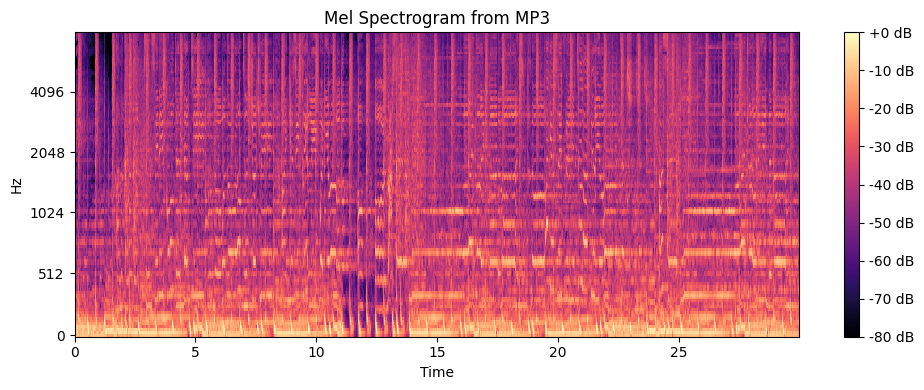

Deleted temporary file preview.mp3


In [43]:
import requests
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

def get_deezer_preview_url(track_name):
    url = f"https://api.deezer.com/search/track?q={track_name}"
    response = requests.get(url)
    data = response.json()
    if data['data']:
        first_track = data['data'][0]
        preview_url = first_track.get('preview')
        return preview_url if preview_url else None
    return None

def download_preview(preview_url, output_filename):
    response = requests.get(preview_url)
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded preview to {output_filename}")

def plot_mel_spectrogram(filename):
    y, sr = librosa.load(filename, sr=None)
    print(f"Audio loaded with {len(y)} samples at {sr} Hz")
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spect_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram from MP3')
    plt.tight_layout()
    plt.show()

def feature_extract(track_name, tmp_filename='preview.mp3'):
    preview_url = get_deezer_preview_url(track_name)
    if preview_url:
        print("Preview URL:", preview_url)
        download_preview(preview_url, tmp_filename)
        plot_mel_spectrogram(tmp_filename)
        os.remove(tmp_filename)
        print(f"Deleted temporary file {tmp_filename}")
    else:
        print("Preview URL not available or track not found.")

# Example usage
feature_extract("blinding lights")


Using deezer to get songs to use

In [1]:

import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

def retry_request(func, max_retries=3, delay=1):
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            time.sleep(delay * (2 ** attempt))
    return None

def get_artist_id(artist_name):
    url = f"https://api.deezer.com/search/artist?q={artist_name}"

    def request_func():
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if 'data' in data and data['data']:
            return data['data'][0]['id']
        else:
            raise ValueError("No data found for artist")

    return retry_request(request_func)

def get_albums(artist_id):
    url = f"https://api.deezer.com/artist/{artist_id}/albums"
    data = requests.get(url).json()
    return data['data'] if 'data' in data else []

def get_tracks(album_id):
    url = f"https://api.deezer.com/album/{album_id}/tracks"
    data = requests.get(url).json()
    return data['data'] if 'data' in data else []

def get_all_tracks_by_artist(artist_name):
    artist_id = get_artist_id(artist_name)
    if not artist_id:
        print(f"Artist not found: {artist_name}")
        return []

    albums = get_albums(artist_id)
    all_tracks = []
    for album in albums:
        tracks = get_tracks(album['id'])
        for track in tracks:
            all_tracks.append({
                'track_title': track['title'],
                'album_title': album['title'],
                'artist_name': artist_name
            })
    return all_tracks

# Load artist names
df = pd.read_csv("artists_uris_cleaned.csv")
artist_names = df['Artists']

all_artists_tracks = []

# Use ThreadPoolExecutor to parallelize artist processing
with ThreadPoolExecutor(max_workers=3) as executor:
    future_to_artist = {executor.submit(get_all_tracks_by_artist, artist): artist for artist in artist_names}
    for future in as_completed(future_to_artist):
        artist = future_to_artist[future]
        try:
            tracks = future.result()
            print(f"Retrieved {len(tracks)} tracks for artist: {artist}")
            all_artists_tracks.extend(tracks)
        except Exception as e:
            print(f"Error processing artist {artist}: {e}")

# Convert collected tracks to DataFrame and save CSV
df_tracks = pd.DataFrame(all_artists_tracks)
df_tracks.to_csv('artist_tracks2.csv', index=False)
print(f"Saved {len(df_tracks)} tracks to artist_tracks2.csv")



Retrieved 293 tracks for artist: The Weeknd
Retrieved 313 tracks for artist: Ed Sheeran
Retrieved 373 tracks for artist: Taylor Swift
Retrieved 140 tracks for artist: Bad Bunny
Retrieved 187 tracks for artist: Dua Lipa
Retrieved 218 tracks for artist: Rihanna
Retrieved 180 tracks for artist: Justin Bieber
Retrieved 220 tracks for artist: Drake
Retrieved 62 tracks for artist: Billie Eilish
Retrieved 150 tracks for artist: Miley Cyrus
Retrieved 119 tracks for artist: Travis Scott
Retrieved 246 tracks for artist: David Guetta
Retrieved 149 tracks for artist: Coldplay
Retrieved 215 tracks for artist: Ariana Grande
Retrieved 186 tracks for artist: Calvin Harris
Retrieved 159 tracks for artist: Shakira
Retrieved 82 tracks for artist: Post Malone
Retrieved 309 tracks for artist: Eminem
Retrieved 44 tracks for artist: Bruno Mars
Retrieved 58 tracks for artist: Doja Cat
Retrieved 293 tracks for artist: Nicki Minaj
Retrieved 0 tracks for artist: Harry Styles
Retrieved 59 tracks for artist: SZA
R

Feature extraction

In [ ]:
import os
import requests
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_deezer_preview_url(track_name):
    url = f"https://api.deezer.com/search/track?q={track_name}"
    response = requests.get(url)
    data = response.json()
    if 'data' in data and data['data']:
        return data['data'][0].get('preview')
    return None

def download_preview(preview_url, output_filename):
    response = requests.get(preview_url)
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded preview to {output_filename}")

def extract_mel_spectrogram_features(filename, n_mels=32, fmax=8000):
    y, sr = librosa.load(filename, sr=None)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    return np.concatenate((mel_spect_db.mean(axis=1), mel_spect_db.std(axis=1)))

def process_single_track(track_title, artist_name=None):
    preview_url = get_deezer_preview_url(track_title)
    if preview_url:
        tmp_filename = f'temp_{track_title[:10].replace(" ", "_")}.mp3'
        try:
            download_preview(preview_url, tmp_filename)
            features = extract_mel_spectrogram_features(tmp_filename)
            os.remove(tmp_filename)

            feature_dict = {
                'track_title': track_title,
                'artist_name': artist_name  # Add artist name here
            }
            for i, val in enumerate(features):
                feature_dict[f'mel_feat_{i}'] = val

            print(f"Processed features for track: {track_title}")
            return feature_dict
        except Exception as e:
            print(f"Error processing {track_title}: {e}")
            return None
    else:
        print(f"No preview URL for track: {track_title}")
        return None


def process_tracks_and_save_features(track_data, output_csv='mel_features.csv', max_workers=3):
    # track_data should be iterable of tuples/list: (track_title, artist_name)
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_track, title, artist): (title, artist) for title, artist in track_data}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                features_list.append(result)

    features_df = pd.DataFrame(features_list)
    features_df.to_csv(output_csv, index=False)
    print(f"Saved features to {output_csv}")


# Example use:
df_tracks = pd.read_csv("part_1.csv")
track_data = zip(df_tracks['track_title'], df_tracks['artist_name'])
process_tracks_and_save_features(track_data)


In [ ]:
import os
import requests
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_deezer_preview_url(track_name):
    url = f"https://api.deezer.com/search/track?q={track_name}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"API request failed with status {response.status_code} for track {track_name}")
        return None
    try:
        data = response.json()
    except ValueError:
        print(f"Invalid JSON response for track {track_name}")
        return None
    if 'data' in data and data['data']:
        return data['data'][0].get('preview')
    return None

def download_preview(preview_url, output_filename):
    response = requests.get(preview_url)
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded preview to {output_filename}")

def extract_mel_spectrogram_features(filename, n_mels=32, fmax=8000):
    y, sr = librosa.load(filename, sr=None)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    return np.concatenate((mel_spect_db.mean(axis=1), mel_spect_db.std(axis=1)))

def process_single_track(track_title, artist_name=None):
    preview_url = get_deezer_preview_url(track_title)
    if preview_url:
        tmp_filename = f'temp_{track_title[:10].replace(" ", "_")}.mp3'
        try:
            download_preview(preview_url, tmp_filename)
            features = extract_mel_spectrogram_features(tmp_filename)
            os.remove(tmp_filename)
            feature_dict = {
                'track_title': track_title,
                'artist_name': artist_name
            }
            for i, val in enumerate(features):
                feature_dict[f'mel_feat_{i}'] = val
            print(f"Processed features for track: {track_title}")
            return feature_dict
        except Exception as e:
            print(f"Error processing {track_title}: {e}")
            return None
    else:
        print(f"No preview URL for track: {track_title}")
        return None

def process_tracks_and_save_features(track_data, output_csv='mel_features.csv', max_workers=3):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_track, title, artist): (title, artist) for title, artist in track_data}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                features_list.append(result)
    features_df = pd.DataFrame(features_list)
    features_df.to_csv(output_csv, index=False)
    print(f"Saved features to {output_csv}")

# Process all part_x.csv files
for i in range(3, 11):
    input_file = f"part_{i}_cleaned.csv"
    output_file = f"mel_features_{i}.csv"
    if os.path.exists(input_file):
        df_tracks = pd.read_csv(input_file)
        track_data = zip(df_tracks['track_title'], df_tracks['artist_name'])
        print(f"Processing {input_file} -> {output_file}")
        process_tracks_and_save_features(track_data, output_csv=output_file)
    else:
        print(f"File {input_file} not found, skipping.")


Processing part_3.csv -> mel_features_3.csv
Downloaded preview to temp_NO_LOS_VI.mp3
Downloaded preview to temp_LuXxX.mp3
Processed features for track: NO LOS VI
Processed features for track: LuXxX
Downloaded preview to temp_DAME_Q.mp3
Processed features for track: DAME Q
Downloaded preview to temp_ALL_INCLUS.mp3
Downloaded preview to temp_DAMN_GIRL.mp3
Processed features for track: ALL INCLUSIVE
Processed features for track: DAMN GIRL
Downloaded preview to temp_BPM.mp3
Processed features for track: BPM
Downloaded preview to temp_Dreams_&_L.mp3
Processed features for track: Dreams & Love
Downloaded preview to temp_Somos_3.mp3
Downloaded preview to temp_NADA_DE_NA.mp3
Processed features for track: NADA DE NADA
Processed features for track: Somos 3
Downloaded preview to temp_Carta_de_D.mp3
Processed features for track: Carta de Despedida
Downloaded preview to temp_Luz_Verde.mp3
Downloaded preview to temp_MAN$ION.mp3
Processed features for track: Luz Verde
Processed features for track: MA

Model Training/Prediction testing

In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 1. Dataset Definition
class MelFeatureDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.X = df[[col for col in df.columns if "mel_feat" in col]].values.astype("float32")
        # Example: Genre or label column (if present)
        self.y = df['genre_id'].values.astype("int64") if 'genre_id' in df.columns else None
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        feat = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.y is not None:
            return feat, torch.tensor(self.y[idx], dtype=torch.long)
        return feat

# 2. Simple Embedding Model
class MelFeatureEmbedding(nn.Module):
    def __init__(self, input_dim=64, embedding_dim=64, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        emb = self.fc2(x)
        logits = self.classifier(emb)
        return logits, emb  # supervised (logits), embedding

# 3. Training Loop (CPU only)
csv_file = 'combined_cleaned.csv'  # change to your file
dataset = MelFeatureDataset(csv_file)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = MelFeatureEmbedding(input_dim=64, embedding_dim=64, num_classes=10)  # Input dimensions corresponds to CSV
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for batch in loader:
        # batch contains (features, labels) if supervised
        if isinstance(batch, tuple):
            feats, labels = batch
        else:
            feats = batch
            labels = None
        optimizer.zero_grad()
        logits, emb = model(feats)  # everything on CPU!
        if labels is not None:
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}" if labels is not None else f"Epoch {epoch+1} completed.")

# After training, use model.eval() and torch.no_grad() to extract embeddings


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.
Epoch 20 completed.
Epoch 21 completed.
Epoch 22 completed.
Epoch 23 completed.
Epoch 24 completed.
Epoch 25 completed.
Epoch 26 completed.
Epoch 27 completed.
Epoch 28 completed.
Epoch 29 completed.
Epoch 30 completed.


In [9]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

# 1. Build embedding database
df = pd.read_csv('mel_features_1.csv')
feature_cols = [col for col in df.columns if "mel_feat" in col]
titles = df['track_title'].tolist()
features = df[feature_cols].values.astype('float32')
features_tensor = torch.tensor(features)

model.eval()
with torch.no_grad():
    _, all_embeddings = model(features_tensor)

# 2. For a new song (or the last entry in your CSV)
new_song = pd.read_csv('mel_features_2.csv')
query_features = torch.tensor(new_song[feature_cols].head(1).values.astype('float32'))  # shape: (1, num_features)
with torch.no_grad():
    _, query_embedding = model(query_features)

# 3. Compute cosine similarity
cos = torch.nn.CosineSimilarity(dim=1)
similarities = cos(query_embedding, all_embeddings)
N = 5  # Number of top predictions you want
top_indices = torch.topk(similarities, N).indices.tolist()
top_titles = [titles[i] for i in top_indices]
print("Top", N, "predicted song titles:", top_titles)

Top 5 predicted song titles: ['First Of May', 'First Of May', 'Colourblind', 'Grow Old with Me', 'Latch (Acoustic)']


User input predictions

In [9]:
import os
import requests
import librosa
import numpy as np

def get_deezer_preview_url(track_name, artist_name=None):
    # Use both track and artist for more accurate search
    query = f"{track_name}"
    if artist_name:
        query += f" {artist_name}"
    url = f"https://api.deezer.com/search/track?q={query}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"API request failed with status {response.status_code} for track {track_name}")
        return None
    try:
        data = response.json()
    except ValueError:
        print(f"Invalid JSON response for track {track_name}")
        return None
    if 'data' in data and data['data']:
        return data['data'][0].get('preview')
    return None

def download_preview(preview_url, output_filename):
    response = requests.get(preview_url)
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded preview to {output_filename}")

def extract_mel_spectrogram_features(filename, n_mels=32, fmax=8000):
    y, sr = librosa.load(filename, sr=None)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    return np.concatenate((mel_spect_db.mean(axis=1), mel_spect_db.std(axis=1)))

def process_user_input_song(track_title, artist_name=None):
    preview_url = get_deezer_preview_url(track_title, artist_name)
    if preview_url:
        tmp_filename = f'temp_{track_title[:10].replace(" ", "_")}.mp3'
        try:
            download_preview(preview_url, tmp_filename)
            features = extract_mel_spectrogram_features(tmp_filename)
            os.remove(tmp_filename)
            print(f"Extracted features for '{track_title}' by '{artist_name}':")
            print(features)
            return features
        except Exception as e:
            print(f"Error processing {track_title}: {e}")
            return None
    else:
        print(f"No preview URL for track: {track_title}")
        return None

artist = input("Enter artist name: ")
song = input("Enter song name: ")
number_of_songs = int(input("Enter number of recommendations: "))
new_song_features = process_user_input_song(song, artist)

import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

# 1. Build embedding database
df = pd.read_csv('combined_cleaned.csv')
feature_cols = [col for col in df.columns if "mel_feat" in col]
titles = df['track_title'].tolist()
artists_names = df['artist_name'].tolist()
features = df[feature_cols].values.astype('float32')
features_tensor = torch.tensor(features)

model.eval()
with torch.no_grad():
    _, all_embeddings = model(features_tensor)

if new_song_features is not None:
    query_features = torch.tensor(new_song_features, dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)
    with torch.no_grad():
        _, query_embedding = model(query_features)
    cos = torch.nn.CosineSimilarity(dim=1)
    similarities = cos(query_embedding, all_embeddings)
    sorted_indices = torch.argsort(similarities, descending=True).tolist()
    filtered_titles = []
    for idx in sorted_indices:
        if titles[idx].strip().lower() != song.strip().lower():
            filtered_titles.append((titles[idx], artists_names[idx]))
        if len(filtered_titles) == number_of_songs:
            break
    print("Top", number_of_songs, "predicted songs (excluding input):")
    for title, artist in filtered_titles:
        print(f"Title: {title} | Artist: {artist}")
else:
    print("Could not extract features for the input song.")


Downloaded preview to temp_Headlines.mp3
Extracted features for 'Headlines' by 'Drake':
[-16.480291  -20.878376  -22.285639  -23.034685  -21.598244  -22.380095
 -25.408464  -27.258831  -29.9439    -31.813656  -33.698406  -34.13086
 -35.34848   -35.789898  -37.268204  -38.29544   -37.76688   -38.50816
 -39.03485   -40.426003  -40.69063   -42.697124  -45.06657   -45.965218
 -47.795853  -49.213425  -50.056473  -49.987747  -49.818653  -50.754696
 -50.10601   -49.742397    8.018854    4.959465    5.2912517   5.961733
   6.8194127   7.294394    7.2782025   7.359715    7.3920856   7.0625315
   7.7073345   7.5167003   7.7147617   7.9822774   7.5218716   7.427835
   7.148718    6.978737    6.959321    7.1346655   6.914701    7.083295
   6.8129363   7.002344    7.963076    8.575535    8.424962    8.333804
   8.950381    9.432635    9.646615    9.56672  ]
Top 5 predicted songs (excluding input):
Title: Headwires | Artist: Foo Fighters
Title: Heartlines | Artist: Florence + The Machine
Title: Prec

In [ ]:
df = pd.read_csv("part_10.csv")
dupes = df[df.duplicated()]
df_no_duplicates = df.drop_duplicates()
df_no_duplicates.to_csv("part_10_cleaned.csv")
print(dupes)

Spotify Integration

In [2]:
## Important imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
from dotenv import load_dotenv
import os
import pandas as pd
# Set up authentication with your Spotify Developer credentials
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")
# sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
#     client_id=client_id,
#     client_secret=client_secret
# ))

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    scope="playlist-modify-public playlist-modify-private",
     client_id=client_id,
    client_secret=client_secret,
    redirect_uri="https://google.com/"
))

user_id = sp.current_user()['id']  # Get your Spotify user ID

# Create a new playlist
playlist = sp.user_playlist_create(
    user=user_id,
    name="My New Playlist",
    public=True,  # Set to False for a private playlist
    description="Created with Spotipy"
)

print("Created playlist:", playlist['name'], "ID:", playlist['id'])


Created playlist: My New Playlist ID: 3oVm1bIrW3ghsV5CvWnXCq


In [3]:
# Example track URI (replace with your desired track)
track_uri = "spotify:track:4iV5W9uYEdYUVa79Axb7Rh"

# Add the track to your playlist
sp.playlist_add_items(playlist_id=playlist['id'], items=[track_uri])

print("Added track to playlist!")


Added track to playlist!


In [4]:
def get_track_uri(song_name, artist_name=None):
    if artist_name:
        query = f"track:{song_name} artist:{artist_name}"
    else:
        query = f"track:{song_name}"
    results = sp.search(q=query, type='track', limit=1)
    if results['tracks']['items']:
        return results['tracks']['items'][0]['uri']
    else:
        return None

# Example usage:
uri = get_track_uri("Shape of You", "Ed Sheeran")
print("Found track URI:", uri)

Found track URI: spotify:track:7qiZfU4dY1lWllzX7mPBI3


Testing using prediction algorithm to add songs to a playlist

In [ ]:
import os
import requests
import librosa
import numpy as np

def get_deezer_preview_url(track_name, artist_name=None):
    # Use both track and artist for more accurate search
    query = f"{track_name}"
    if artist_name:
        query += f" {artist_name}"
    url = f"https://api.deezer.com/search/track?q={query}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"API request failed with status {response.status_code} for track {track_name}")
        return None
    try:
        data = response.json()
    except ValueError:
        print(f"Invalid JSON response for track {track_name}")
        return None
    if 'data' in data and data['data']:
        return data['data'][0].get('preview')
    return None

def download_preview(preview_url, output_filename):
    response = requests.get(preview_url)
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded preview to {output_filename}")

def extract_mel_spectrogram_features(filename, n_mels=32, fmax=8000):
    y, sr = librosa.load(filename, sr=None)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    return np.concatenate((mel_spect_db.mean(axis=1), mel_spect_db.std(axis=1)))

def process_user_input_song(track_title, artist_name=None):
    preview_url = get_deezer_preview_url(track_title, artist_name)
    if preview_url:
        tmp_filename = f'temp_{track_title[:10].replace(" ", "_")}.mp3'
        try:
            download_preview(preview_url, tmp_filename)
            features = extract_mel_spectrogram_features(tmp_filename)
            os.remove(tmp_filename)
            print(f"Extracted features for '{track_title}' by '{artist_name}':")
            print(features)
            return features
        except Exception as e:
            print(f"Error processing {track_title}: {e}")
            return None
    else:
        print(f"No preview URL for track: {track_title}")
        return None

artist = input("Enter artist name: ")
song = input("Enter song name: ")
number_of_songs = int(input("Enter number of recommendations: "))
new_song_features = process_user_input_song(song, artist)

import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

# 1. Build embedding database
df = pd.read_csv('combined_cleaned.csv')
feature_cols = [col for col in df.columns if "mel_feat" in col]
titles = df['track_title'].tolist()
artists_names = df['artist_name'].tolist()
features = df[feature_cols].values.astype('float32')
features_tensor = torch.tensor(features)

model.eval()
with torch.no_grad():
    _, all_embeddings = model(features_tensor)

if new_song_features is not None:
    query_features = torch.tensor(new_song_features, dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)
    with torch.no_grad():
        _, query_embedding = model(query_features)
    cos = torch.nn.CosineSimilarity(dim=1)
    similarities = cos(query_embedding, all_embeddings)
    sorted_indices = torch.argsort(similarities, descending=True).tolist()
    filtered_titles = []
    for idx in sorted_indices:
        if titles[idx].strip().lower() != song.strip().lower():
            filtered_titles.append((titles[idx], artists_names[idx]))
        if len(filtered_titles) == number_of_songs:
            break
    print("Top", number_of_songs, "predicted songs (excluding input):")
    for title, artist in filtered_titles:
        print(f"Title: {title} | Artist: {artist}")
else:
    print("Could not extract features for the input song.")

for title, artist in filtered_titles:
    uri = get_track_uri(title, artist)
    sp.playlist_add_items(playlist_id=playlist['id'], items=[uri])

{'snapshot_id': 'AAAAA7MLSr+A+UApKNkZ2rxkbdQzfZs4'}